# 1.Imports 

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

2023-11-13 00:33:41.731168: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 00:33:41.731200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 00:33:41.731237: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 00:33:41.738533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(123)

# Set random seed for NumPy
np.random.seed(123)

# 2.Loading data

In [3]:
base_dir='skin-disease-datasaet/train_set' 
base_dir2='skin-disease-datasaet/test_set'
IMAGE_SIZE=256
BATCH_SIZE=8

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-11-13 00:33:43.251189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 00:33:43.256325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 00:33:43.256507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
#pre=processing
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    

    )

test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
     rescale=1./255,
 
)

train_generator=train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
 
)

test_generator=test_datagen.flow_from_directory(
    base_dir2,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False, 
)

Found 924 images belonging to 8 classes.
Found 233 images belonging to 8 classes.


# 3.CNN Architecture

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

cnn = Sequential()
cnn.add(base_model)

cnn.add(GlobalAveragePooling2D())

cnn.add(Dense(8, activation='softmax'))

cnn.summary()

2023-11-13 00:33:43.329197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 00:33:43.329415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 00:33:43.329567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 23604104 (90.04 MB)
Trainable params: 23550984 (89.84 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [10]:
import tensorflow as tf

def precision(y_true, y_pred):
    true_positives = tf.math.reduce_sum(tf.math.round(tf.math.multiply(y_true, y_pred)))
    predicted_positives = tf.math.reduce_sum(tf.math.round(y_pred))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall(y_true, y_pred):
    true_positives = tf.math.reduce_sum(tf.math.round(tf.math.multiply(y_true, y_pred)))
    actual_positives = tf.math.reduce_sum(y_true)
    return true_positives / (actual_positives + tf.keras.backend.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + tf.keras.backend.epsilon()))

In [11]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 23604104 (90.04 MB)
Trainable params: 23550984 (89.84 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


# 4. training the model

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "resnet.h5"

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', precision, recall, f1_score]
)

hist = cnn.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[checkpoint, early_stopping])

Epoch 1/20


2023-11-13 00:33:52.343040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-13 00:33:52.461311: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-13 00:33:52.618782: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-13 00:33:53.648336: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x98df2b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 00:33:53.648356: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-11-13 00:33:53.652610: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 00:33:53.728669: I ./tensorflow/compiler/jit/device_compiler.

116/116 [==============================] - ETA: 0s - loss: 2.1803 - accuracy: 0.2944 - precision: 0.2673 - recall: 0.0851 - f1_score: 0.1207
Epoch 1: saving model to resnet.h5


/home/zeyd/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 34s 128ms/step - loss: 2.1803 - accuracy: 0.2944 - precision: 0.2673 - recall: 0.0851 - f1_score: 0.1207 - val_loss: 18611.1426 - val_accuracy: 0.1416 - val_precision: 0.1375 - val_recall: 0.1375 - val_f1_score: 0.1375
Epoch 2/20
116/116 [==============================] - ETA: 0s - loss: 1.7360 - accuracy: 0.3907 - precision: 0.3779 - recall: 0.1067 - f1_score: 0.1594
Epoch 2: saving model to resnet.h5
116/116 [==============================] - 11s 93ms/step - loss: 1.7360 - accuracy: 0.3907 - precision: 0.3779 - recall: 0.1067 - f1_score: 0.1594 - val_loss: 2.0897 - val_accuracy: 0.1416 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/20
116/116 [==============================] - ETA: 0s - loss: 1.4680 - accuracy: 0.5032 - precision: 0.6204 - recall: 0.2522 - f1_score: 0.3455
Epoch 3: saving model to resnet.h5
116/116 [==============================] - 11s 92ms/step - loss: 1.4680 - accuracy: 0.5032 - pr

In [13]:
last_epoch = len(hist.history['loss'])  

metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']

for metric_name in metric_names:
    last_value = hist.history[metric_name][last_epoch - 1]
    print(f"{metric_name}: {last_value:.4f}")

loss: 0.0922
accuracy: 0.9708
precision: 0.9726
recall: 0.9677
f1_score: 0.9700


In [14]:
last_epoch = len(hist.history['loss']) - 1 

metric_names = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']

for metric_name in metric_names:
    training_value = hist.history[metric_name][last_epoch]
    validation_value = hist.history[f'val_{metric_name}'][last_epoch]
    print(f"{metric_name}:")
    print(f"  Training: {training_value:.4f}")
    print(f"  Validation: {validation_value:.4f}")

loss:
  Training: 0.0922
  Validation: 0.8173
accuracy:
  Training: 0.9708
  Validation: 0.8283
precision:
  Training: 0.9726
  Validation: 0.8423
recall:
  Training: 0.9677
  Validation: 0.8042
f1_score:
  Training: 0.9700
  Validation: 0.8216


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred = cnn.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.labels


confusion = confusion_matrix(y_true, y_pred)


print("Confusion Matrix:")
print(confusion)

report = classification_report(y_true, y_pred)

# Print the classification report
print("Classification Report:")
print(report)


30/30 [==============================] - 1s 25ms/step
Confusion Matrix:
[[27  0  4  0  0  1  1  0]
 [ 2 18  0  0  0  0  0  0]
 [ 2  3 27  0  0  0  0  0]
 [ 0  0  0 33  0  0  0  0]
 [ 4  0  0  0 16  0  0  3]
 [ 4  2  2  0  2 13  1  1]
 [ 0  1  1  0  2  1 29  0]
 [ 2  0  0  0  0  1  0 30]]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73        33
           1       0.75      0.90      0.82        20
           2       0.79      0.84      0.82        32
           3       1.00      1.00      1.00        33
           4       0.80      0.70      0.74        23
           5       0.81      0.52      0.63        25
           6       0.94      0.85      0.89        34
           7       0.88      0.91      0.90        33

    accuracy                           0.83       233
   macro avg       0.83      0.82      0.82       233
weighted avg       0.84      0.83      0.83       233



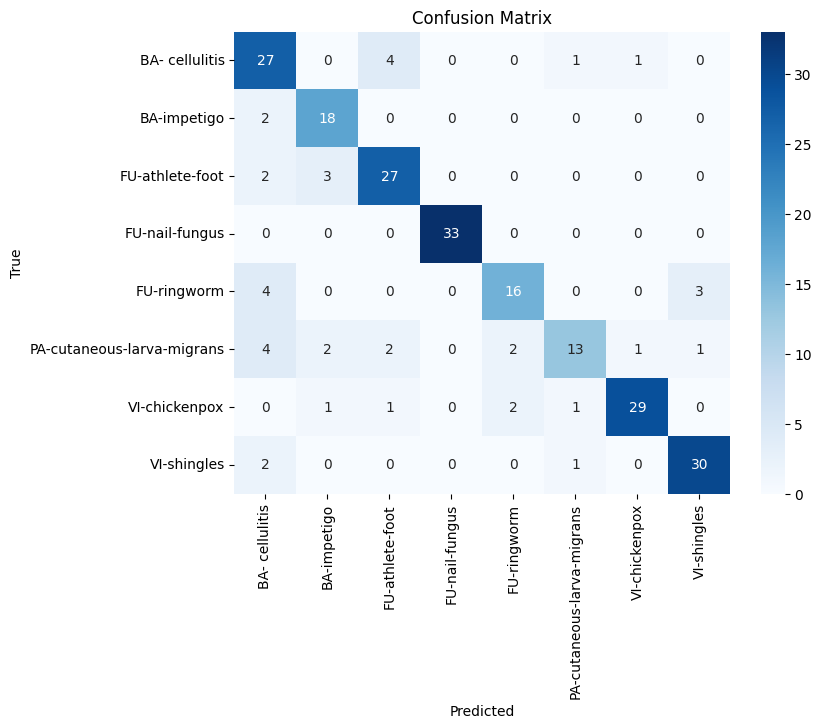

In [16]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [17]:
from matplotlib import pyplot as plt

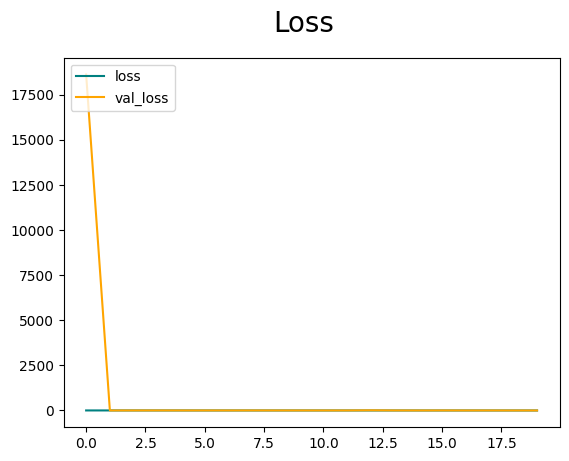

In [18]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

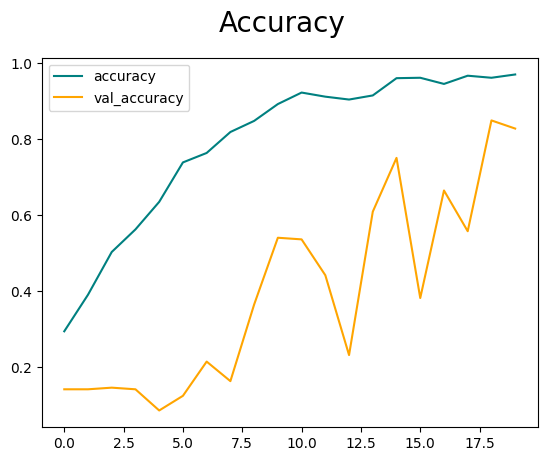

In [19]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()